In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from fastaudio.augment.spectrogram import CropTime

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [5]:
FOLD=3

In [6]:
path = Path("/home/kkalyan/agri-split/data")
df = pd.read_csv(path/"Train_v.csv")

In [7]:
#ct = CropTime(duration=1000)
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [8]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [9]:
# , SignalShifter(), AddNoise(), ChangeVolume()

In [10]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss(), 
                            SGRoll(), Delta(), MaskTime(), MaskFreq()],
                 get_y=ColReader("label"))

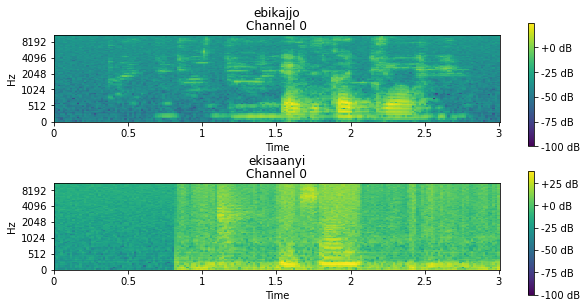

In [11]:
dbunch = auds.dataloaders(df, bs=128)
dbunch.show_batch(figsize=(10, 5))

In [12]:
learn = cnn_learner(dbunch, 
            resnet18,
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

In [13]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,7.289560,6.658215,0.016260,00:04


epoch,train_loss,valid_loss,accuracy,time
0,7.124733,5.981443,0.005420,00:05
1,7.151005,5.820250,0.005420,00:04
2,7.139743,5.730583,0.005420,00:04


In [14]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,6.823260,5.747152,0.008130,00:04
1,6.791222,5.722433,0.016260,00:04
2,6.745854,5.783061,0.013550,00:04
3,6.712449,5.684917,0.013550,00:04
4,6.651820,5.646400,0.013550,00:04
5,6.602608,5.727534,0.008130,00:04
6,6.563238,5.690292,0.018970,00:04
7,6.469504,5.668290,0.016260,00:04
8,6.388144,5.490045,0.035230,00:04
9,6.293912,5.449061,0.027100,00:04


Better model found at epoch 0 with valid_loss value: 5.747152328491211.
Better model found at epoch 1 with valid_loss value: 5.722432613372803.
Better model found at epoch 3 with valid_loss value: 5.684916973114014.
Better model found at epoch 4 with valid_loss value: 5.646400451660156.
Better model found at epoch 8 with valid_loss value: 5.490044593811035.
Better model found at epoch 9 with valid_loss value: 5.449060916900635.
Better model found at epoch 10 with valid_loss value: 5.3739519119262695.
Better model found at epoch 11 with valid_loss value: 5.319473743438721.
Better model found at epoch 12 with valid_loss value: 5.134139060974121.
Better model found at epoch 13 with valid_loss value: 5.037203788757324.
Better model found at epoch 14 with valid_loss value: 4.922242641448975.
Better model found at epoch 15 with valid_loss value: 4.839900970458984.
Better model found at epoch 16 with valid_loss value: 4.640012264251709.
Better model found at epoch 17 with valid_loss value: 4.

In [15]:
ac_1 = learn.validate(); ac_1

(#2) [3.2284040451049805,0.4065040647983551]

In [16]:
# Better model found at epoch 95 with valid_loss value: 4.031138896942139.
# (#2) [4.1059250831604,0.23848238587379456